# Initialize a game

In [1]:
from ConnectN import ConnectN
from Play import Play

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import *
import numpy as np

from ConnectN import ConnectN
game_setting = {'size':(6,6), 'N':4}
game = ConnectN(**game_setting)

class Policy(nn.Module):

    def __init__(self, game):
        super(Policy, self).__init__()

        # input = 6x6 board
        # convert to 5x5x16
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2, stride=1, bias=False)
        # 5x5x16 to 3x3x32
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, bias=False)

        self.size=3*3*32
        
        # the part for actions
        self.fc_action1 = nn.Linear(self.size, self.size//4)
        self.fc_action2 = nn.Linear(self.size//4, 36)
        
        # the part for the value function
        self.fc_value1 = nn.Linear(self.size, self.size//6)
        self.fc_value2 = nn.Linear(self.size//6, 1)
        self.tanh_value = nn.Tanh()
        
    def forward(self, x):

        y = F.leaky_relu(self.conv1(x))
        y = F.leaky_relu(self.conv2(y))
        y = y.view(-1, self.size)
        
        # action head
        a = self.fc_action2(F.leaky_relu(self.fc_action1(y)))
        
        avail = (torch.abs(x.squeeze())!=1).type(torch.FloatTensor)
        avail = avail.reshape(-1, 36)
        maxa = torch.max(a)
        exp = avail*torch.exp(a-maxa)
        prob = exp/torch.sum(exp)
        
        # value head
        value = self.tanh_value(self.fc_value2(F.leaky_relu( self.fc_value1(y) )))
        return prob.view(6,6), value

policy = Policy(game)


# Define a MCTS player for Play

In [3]:
import MCTS

from copy import copy

def Policy_Player_MCTS(game):
    mytree = MCTS.Node(copy(game))
    for _ in range(2000):
        mytree.explore(policy)
       
    mytreenext, (v, nn_v, p, nn_p) = mytree.next(temperature=0.1)
    
    return mytreenext.game.last_move

import random

def Random_Player(game):
    return random.choice(game.available_moves())    


In [4]:
# initialize our alphazero agent and optimizer
import torch.optim as optim


game=ConnectN(**game_setting)
policy = Policy(game)
#optimizer = optim.Adam(policy.parameters(), lr=.005, weight_decay=1.e-5)


# setup environment to pit your AI against the challenge policy '6-6-4-pie.policy'

In [5]:
import torch

challenge_policy = torch.load('6-6-4-pie-27000.policy')

def Challenge_Player_MCTS(game):
    mytree = MCTS.Node(copy(game))
    for _ in range(1000):
        mytree.explore(challenge_policy)
       
    mytreenext, (v, nn_v, p, nn_p) = mytree.next(temperature=0.1)
    
    return mytreenext.game.last_move



# Playing with MCTS only

<IPython.core.display.Javascript object>


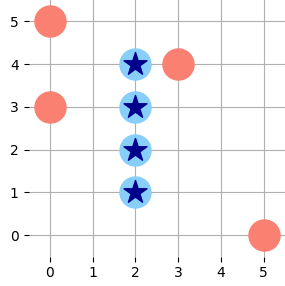

In [7]:
# You play second
%matplotlib notebook
gameplay=Play(ConnectN(**game_setting), 
              player2=None, 
              player1=Policy_Player_MCTS)

# Playing with the Rockstar trained agent!

<IPython.core.display.Javascript object>


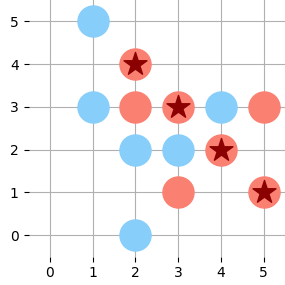

In [8]:
# You play second
%matplotlib notebook
gameplay=Play(ConnectN(**game_setting), 
              player2=None, 
              player1=Challenge_Player_MCTS)

<IPython.core.display.Javascript object>


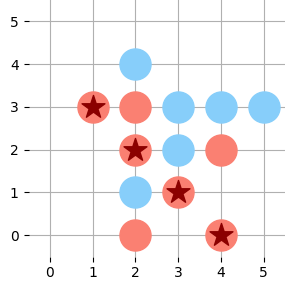

In [9]:
# You play first
%matplotlib notebook
gameplay=Play(ConnectN(**game_setting), 
              player1=None, 
              player2=Challenge_Player_MCTS)


<IPython.core.display.Javascript object>


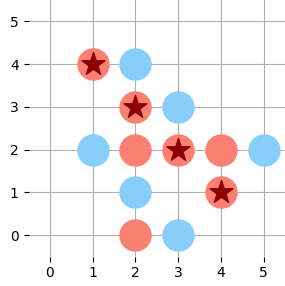

In [101]:
# 2 AIs play
%matplotlib notebook
gameplay=Play(ConnectN(**game_setting), 
              player1=Challenge_Player_MCTS, 
              player2=Challenge_Player_MCTS)